In [13]:
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

In [62]:
def plot_with_cbar(image,cmap="jet"):
    ax = plt.subplot()
    im=ax.imshow(image, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

    
def seg_no_cents(points_msg,hg=0.85,lg=1.5,th_v=0.03,lower=1000 ,higher=50000,reg_ly= 30,reg_hy=600,plot=False):
    points_data = ros_numpy.numpify(points_msg)    
    image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
    image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
    image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #print (image.shape)

    _,corrected=correct_points(points_msg)
    # quito NaN
    zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)
    histogram, bin_edges =(np.histogram(zs_no_nans, bins=100))
    t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
    trans=t.transform.translation.z
    # Obtengo la altura del sensor respecto a la base-piso
    plane_height= (trans)+bin_edges[histogram[:-1].argmax()+1]
    #print(plane_height)
    if plane_height<0.1:
        #print("Segmentacion en: Piso, lg:",lg)
        im_corrected=segment_floor(points_data,zs_no_nans,obj_hMax=hg,obj_lMax=lg,thres_floor=th_v)
    else:
        #print("Segmentacion en: Mesa")
        im_corrected=segment_table(points_data,zs_no_nans,obj_lMax=lg,thres_t=th_v)

    if plot:
        cv2.imshow("Image to segment",im_corrected)
        cv2.waitKey(0)

        cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(im_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours
    drawing = np.zeros((im_corrected.shape[0], im_corrected.shape[1], 3), dtype=np.uint8)
    for i in range(len(contours)):
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        cv2.drawContours(drawing, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
    # Show in a window
    cv2.imshow('Contours', drawing)
    cv2.waitKey(0)
    
    return contours

def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    area_of_intersection = i_height * i_width
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    iou = area_of_intersection / area_of_union
    return iou


def get_union_rectangle(data,bkg):
    print(len(data))
    #c=np.r_[0:len(data)-1]
    #print(c)
    newR=[]
    bkg2=np.copy(bkg)
    comb= [(i, j) for i in np.r_[0:len(data)-1] for j in np.r_[0:len(data)-1] if i < j]
    print(comb)
    for c in comb:
        print(c[0],c[1])
        res=get_iou(data[c[0]],data[c[1]])
        if res>0:
            unionRec=[min(data[c[0]][0],data[c[1]][0]),
            min(data[c[0]][1],data[c[1]][1]),
            max(data[c[0]][2],data[c[1]][2]),
            max(data[c[0]][3],data[c[1]][3])]
            newR.append(unionRec)
            bkg2=cv2.rectangle(bkg2, (unionRec[1], unionRec[0]),(unionRec[3], unionRec[2]), (255,0,0), 3)
            
        else:
            newR.append(data[c[0]])
    return bkg2,newR


def nothing(x):
    pass


In [24]:
contours=seg_no_cents(points_msg,hg=hg,lg=lg,th_v=thres_f,lower=minA, higher=maxA,reg_ly= low_y,reg_hy=hi_y,plot=False)
cv2.destroyAllWindows()


In [60]:
l=500
h=5000
zer=np.zeros((im_corrected.shape[0], im_corrected.shape[1], 3), dtype=np.uint8)

areas=[]

for i, c in enumerate(contours):
    area=cv2.contourArea(c)
    #print(area)
    if area > l and area < h :
        boundRect = cv2.boundingRect(c)
        #print(boundRect)
        #cv2.rectangle(zer,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]),
                      #(255,255,0), 2)
        #cv2.putText(zer, "i:"+str(i) ,    (boundRect[0], boundRect[1])   ,
                    #cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        areas.append([[i],[boundRect[0], boundRect[1],boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]]])     

k=1

#areas_2=[]

#for p in areas:
#    if k==len(areas):
        #areas_2.append(p)
#        break
        
#    print(p,"---")
#    for i in range(k,len(areas)):
        #if areas[i][0][0] >= p[1][0] and areas[i][0][1] < p[1][1]:  
#        print(k,areas[i],areas[i][1][0])
#    k+=1
        
#cv2.imshow("R",zer)
#cv2.waitKey(0)

#cv2.destroyAllWindows()



[[1], [123, 265, 190, 297]] ---
1 [[4], [125, 242, 187, 267]] 125
1 [[12], [316, 151, 386, 172]] 316
[[4], [125, 242, 187, 267]] ---
2 [[12], [316, 151, 386, 172]] 316


In [67]:
print(areas[0][1])

[123, 265, 190, 297]


In [61]:
p1=(5,5)
r1=(3,3)
r2=(6,6)

if p1>r1 and p1<r2:
    print("SI")

SI


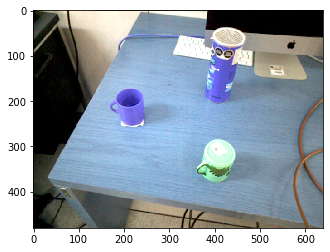

In [75]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
plt.imshow(image)


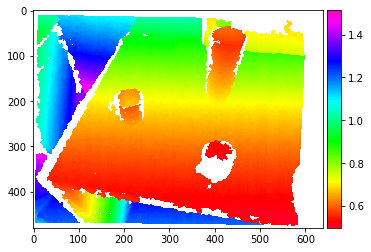

In [76]:
plot_with_cbar(points_data['z'],cmap="gist_rainbow")


S key pressed
cent out of region... rejected


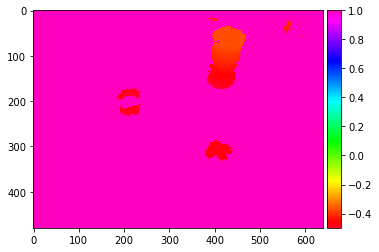

S key pressed


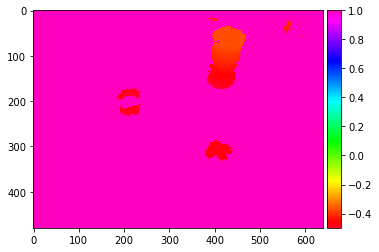

S key pressed
cent out of region... rejected


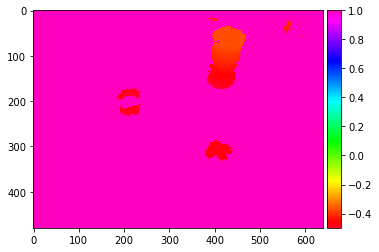

S key pressed
cent out of region... rejected


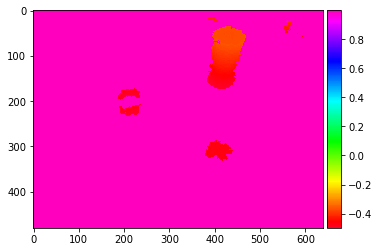

S key pressed
cent out of region... rejected
cent out of region... rejected


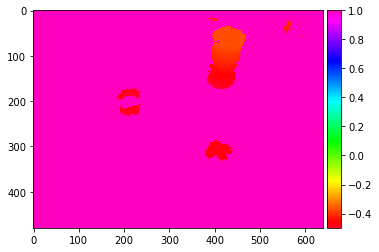

In [77]:
cv2.namedWindow('class rgbd')
cv2.createTrackbar('Max Area', 'class rgbd', 0, 480*640, nothing)   ### AREA MAX IS THE WHOLE IMAGE 
cv2.createTrackbar('Min Area', 'class rgbd', 0, 2000, nothing)   ### AREA MAX IS THE WHOLE IMAGE 
cv2.createTrackbar('Hi limit pix y', 'class rgbd',240,480,nothing)
cv2.createTrackbar('Lo limit pix y', 'class rgbd',0,240,nothing)
cv2.createTrackbar('max depth (cm)', 'class rgbd',0,500,nothing)
cv2.createTrackbar('threshold floor (mm)', 'class rgbd',0,1000,nothing)
cv2.createTrackbar('object height (cm)', 'class rgbd',0,150,nothing)

# SET YAML VAR
# hg --> height of the object
# lg --> lenght of depth
hg= 0.3
lg= 0.7
thres_f=0.04
higher= 17989
lower= 276
reg_hy= 450
reg_ly= 93
    
hg=int(hg*100)
lg=int(lg*100)
thres_f=int(thres_f*1000)
cv2.setTrackbarPos('Max Area', 'class rgbd',higher) 
cv2.setTrackbarPos('Min Area', 'class rgbd',lower) 
cv2.setTrackbarPos('Hi limit pix y','class rgbd',reg_hy) 
cv2.setTrackbarPos('Lo limit pix y','class rgbd',reg_ly) 
cv2.setTrackbarPos('max depth (cm)','class rgbd',lg) 
cv2.setTrackbarPos('threshold floor (mm)','class rgbd',thres_f) 
cv2.setTrackbarPos('object height (cm)', 'class rgbd',hg)
#

#cv2.waitKey(0)
#cv2.destroyAllWindows()
cnt=0
img=np.copy(image)
while(1):    
    #df = read_segmentation_yaml()
    
    maxA = cv2.getTrackbarPos('Max Area', 'class rgbd')
    minA = cv2.getTrackbarPos('Min Area', 'class rgbd')
    hi_y = cv2.getTrackbarPos('Hi limit pix y', 'class rgbd')
    low_y = cv2.getTrackbarPos('Lo limit pix y', 'class rgbd')
    lg = cv2.getTrackbarPos('max depth (cm)', 'class rgbd')/100
    thres_f = cv2.getTrackbarPos('threshold floor (mm)', 'class rgbd')/1000
    hg = cv2.getTrackbarPos('object height (cm)', 'class rgbd')/100
    
    
    #print(hg2,lg2)
    
    k = cv2.waitKey(10) & 0xFF
    #print("KEY",k)
    if k == 115:
        cnt+=1
        print("S key pressed")
        cents,xyz, images, img ,im_corrected= plane_seg2(points_msg,hg=hg,lg=lg,th_v=thres_f,lower=minA, higher=maxA,reg_ly= low_y,reg_hy=hi_y,plot=False)
        plot_with_cbar(im_corrected,cmap="gist_rainbow")
    img[0:low_y,:,:]=0
    img[hi_y:,:,:]=0
    
    #cv2.line(im2,(0,hi_y),(640,hi_y),(0, 255, 0),3)
    #cv2.line(im2,(0,low_y),(640,low_y),(255, 255, 0),3)
    cv2.putText(img,"Conteo 's': "+str(cnt),org=(5,40),fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.5, color=(35, 255, 148),thickness=2)
    cv2.putText(img,"hg: "+ str(hg)+" lg: "+str(lg), org=(5, 20),fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.6, color=(35, 255, 148),thickness=2)
    
    #print(maxA,type(maxA))
    cv2.imshow('class rgbd'  , img)
    cv2.waitKey(10)
    # k == 'q'
    if k==113:
        break
cv2.destroyAllWindows()
   

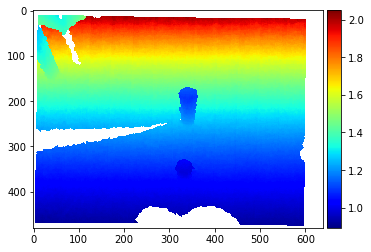

In [10]:
plot_with_cbar(points_data['z'])

In [40]:
print(np.amin(zs_no_nans))

-1.3257776


# Pruebas por separado

# PISO

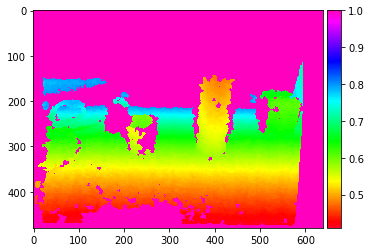

In [27]:
_,corrected=correct_points(points_msg)
zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)

plot_with_cbar(zs_no_nans,cmap="gist_rainbow")

-1.0290871


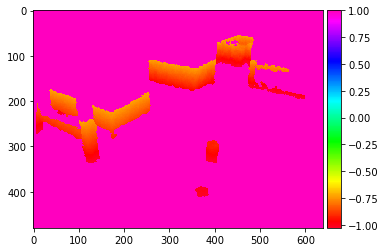

In [42]:
trans=0.9790871
thres_floor=0.05
obj_hMax=0.3
print(-trans-thres_floor)
img_corrected = np.where((zs_no_nans >-trans-thres_floor),zs_no_nans,1)
img_corrected = np.where((img_corrected < -trans-thres_floor+obj_hMax),img_corrected,1)

plot_with_cbar(img_corrected,cmap="gist_rainbow")


ls no nans


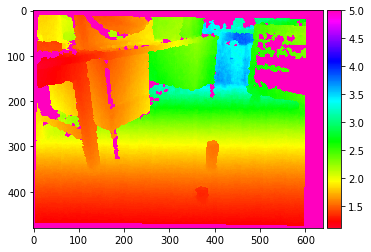

image sin objetos lejanos


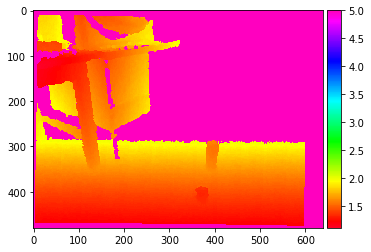

In [50]:
obj_lMax=2.0
ls_no_nans=np.where(~np.isnan(points_data['z']),points_data['z'],5)
print("ls no nans")
plot_with_cbar(ls_no_nans,cmap="gist_rainbow")
lZ_no_nans=np.where(ls_no_nans<obj_lMax,ls_no_nans,5)
print("image sin objetos lejanos")
plot_with_cbar(lZ_no_nans,cmap="gist_rainbow")


image to process


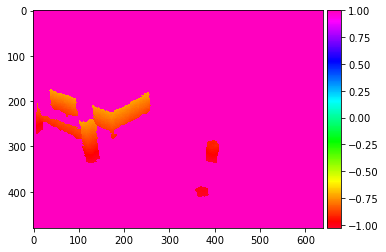

In [51]:
for r in range(img_corrected.shape[0]):
    for c in range(img_corrected.shape[1]):
        if lZ_no_nans[r,c]>=5:
            img_corrected[r,c]=1
print("image to process")
plot_with_cbar(img_corrected,cmap="gist_rainbow")

# MESA

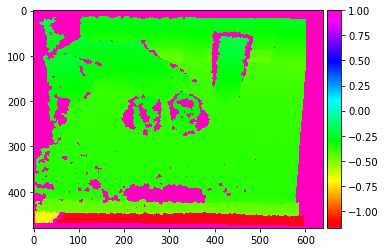

In [6]:
_,corrected=correct_points(points_msg)
zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)

plot_with_cbar(zs_no_nans,cmap="gist_rainbow")

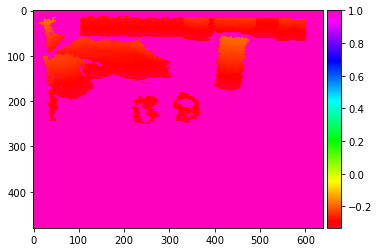

In [7]:
trans = 1.0782
plane_height = 0.7356
thres_t = 0.01
img_corrected = np.where((-zs_no_nans <  (trans*0.999)-plane_height-thres_t),zs_no_nans,1)
plot_with_cbar(img_corrected,cmap="gist_rainbow")


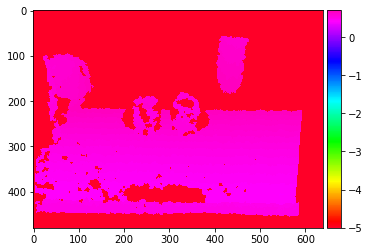

In [9]:
obj_lMax = 0.7
lenZ_no_nans=np.where(~np.isnan(points_data['z']),points_data['z'],-5)
lenZ_corrected=np.where(lenZ_no_nans<obj_lMax,lenZ_no_nans,-5)

plot_with_cbar(lenZ_corrected,cmap="gist_rainbow")


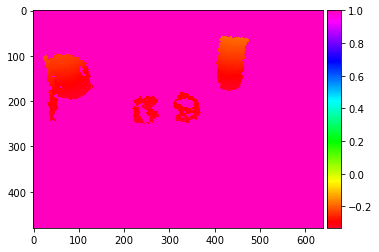

In [10]:
for r in range(img_corrected.shape[0]):
    for c in range(img_corrected.shape[1]):
        if lenZ_corrected[r,c]<=-5:
            img_corrected[r,c]=1

plot_with_cbar(img_corrected,cmap="gist_rainbow")


In [20]:
cv2.destroyAllWindows()
